In [159]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import warnings
warnings.filterwarnings('ignore');

In [160]:
train_columns = ['Age', 'Work Class', 'Final Weight', 'Education', 'Education Number', 'Marital Status', 'Occupation',
          'Relationship', 'Race', 'Sex', 'Capital Gain', 'Capital Loss', 'Hours per Week', 'Country', 'Income']

test_columns = ['ID','Age', 'Work Class', 'Final Weight', 'Education', 'Education Number', 'Marital Status', 'Occupation',
          'Relationship', 'Race', 'Sex', 'Capital Gain', 'Capital Loss', 'Hours per Week', 'Country']


train_data = pd.read_csv('train_final.csv', names = train_columns)
test_data = pd.read_csv('test_final.csv', names=test_columns)

# Imputer to change ? values
imp = SimpleImputer(missing_values='?', strategy="most_frequent")

# Change ? values to the most_frequent value of the feature
train_data = pd.DataFrame(imp.fit_transform(train_data), columns=train_columns)
test_data = pd.DataFrame(imp.fit_transform(test_data), columns=test_columns)

In [161]:
train_data["Age"] = train_data["Age"].astype(int)
train_data["Final Weight"] = train_data["Final Weight"].astype(int)
train_data["Education Number"] = train_data["Education Number"].astype(int)
train_data["Capital Gain"] = train_data["Capital Gain"].astype(int)
train_data["Capital Loss"] = train_data["Capital Loss"].astype(int)
train_data["Hours per Week"] = train_data["Hours per Week"].astype(int)
train_data["Income"] = train_data["Income"].astype(int)

train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               25000 non-null  int32 
 1   Work Class        25000 non-null  object
 2   Final Weight      25000 non-null  int32 
 3   Education         25000 non-null  object
 4   Education Number  25000 non-null  int32 
 5   Marital Status    25000 non-null  object
 6   Occupation        25000 non-null  object
 7   Relationship      25000 non-null  object
 8   Race              25000 non-null  object
 9   Sex               25000 non-null  object
 10  Capital Gain      25000 non-null  int32 
 11  Capital Loss      25000 non-null  int32 
 12  Hours per Week    25000 non-null  int32 
 13  Country           25000 non-null  object
 14  Income            25000 non-null  int32 
dtypes: int32(7), object(8)
memory usage: 2.2+ MB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001FF4CA87438>,
      dtype=object)

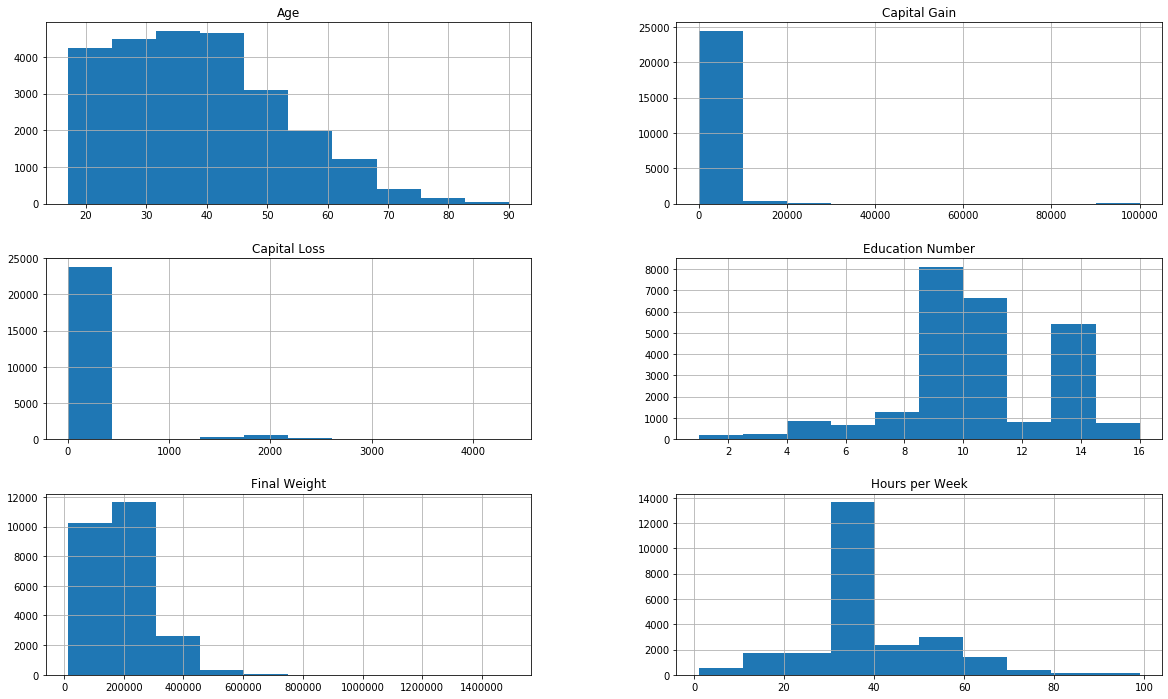

In [162]:
# I want to visual the data sets.

rcParams['figure.figsize'] = 20, 12
train_data[['Age', 'Final Weight', 'Education Number', 'Capital Gain', 'Capital Loss', 'Hours per Week']].hist()

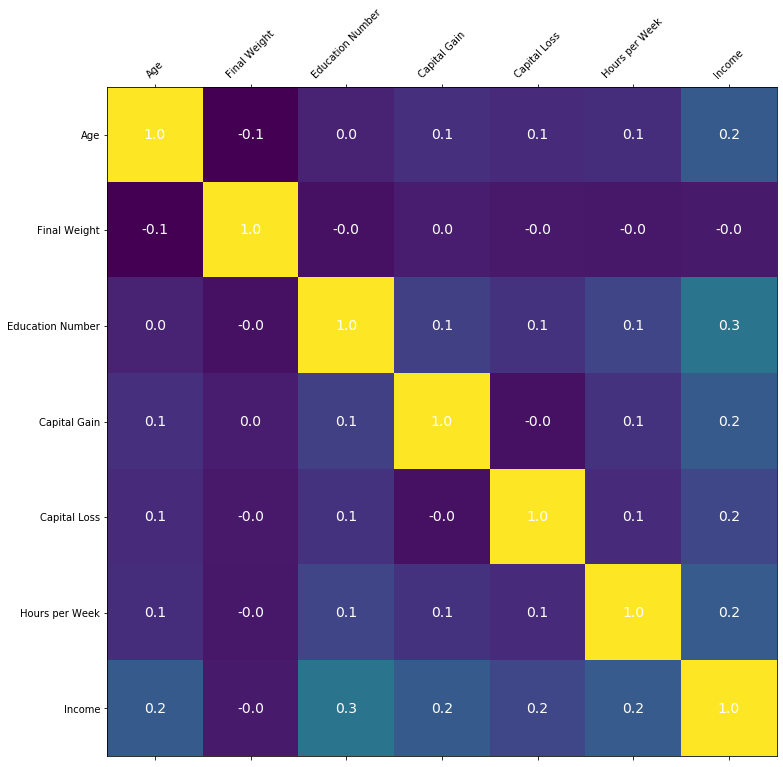

In [163]:
plt.matshow(train_data.corr())
plt.xticks(np.arange(len(train_data.corr().columns)), train_data.corr().columns.values, rotation = 45) 
plt.yticks(np.arange(len(train_data.corr().columns)), train_data.corr().columns.values) 
for (i, j), corr in np.ndenumerate(train_data.corr()):
    plt.text(j, i, '{:0.001f}'.format(corr), ha='center', va='center', color='white', fontsize=14)

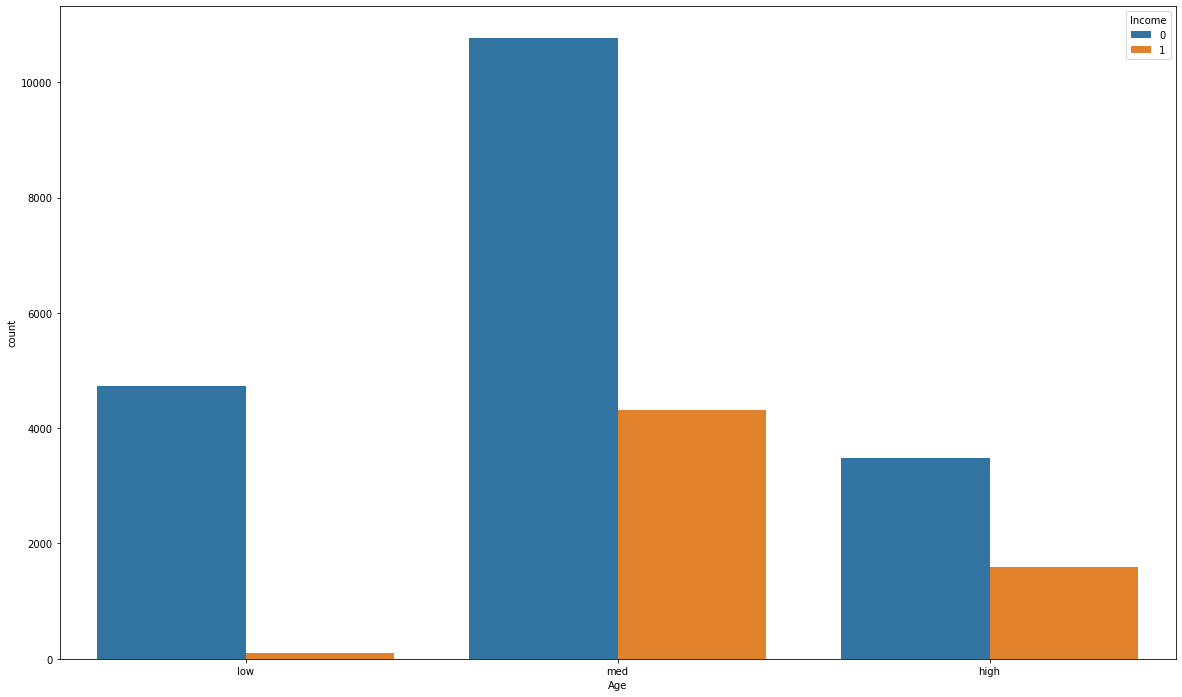

In [164]:
# Move Age into bins
train_data['Age'] = pd.cut(train_data['Age'], bins = [0, 25, 50, 100], labels = ["low", "med", "high"])
sns.countplot(x = 'Age', hue = 'Income', data = train_data)

In [165]:
# Final Weight has no correlation to Income. Drop it!
train_data.drop(['Final Weight'], axis=1, inplace=True)

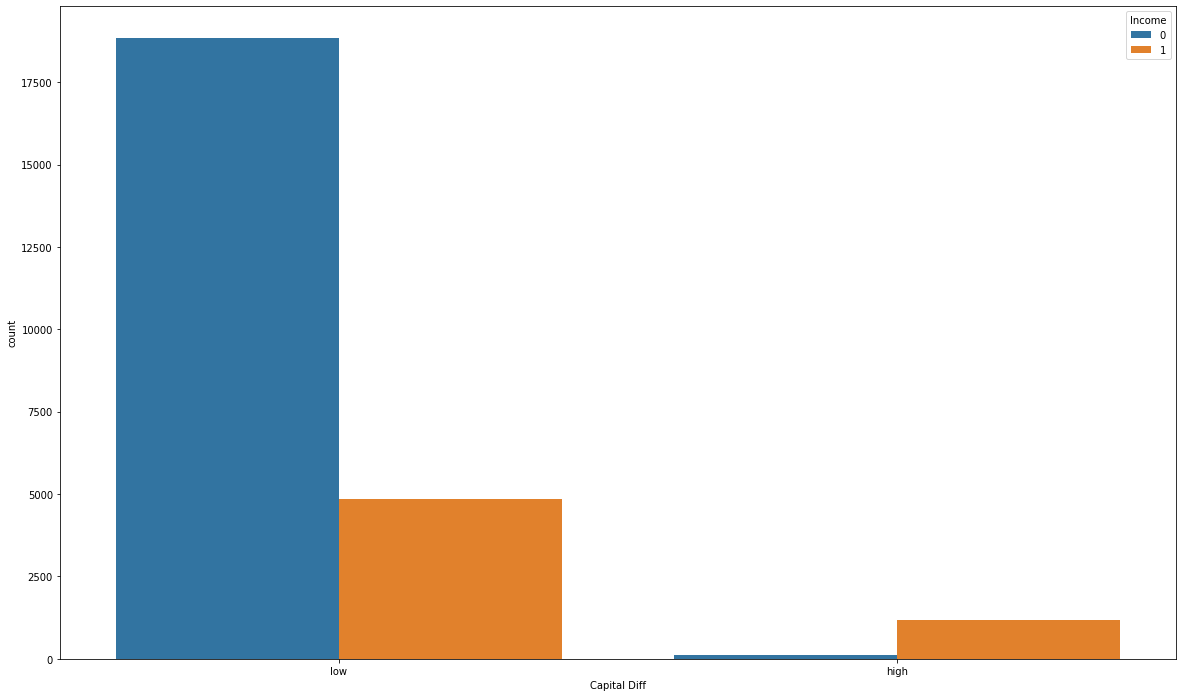

In [166]:
# I want to reduce the amount of features. Capital gain and loss are generally zero and can be reduced
# into one column by subracting them.
train_data['Capital Diff'] = train_data['Capital Gain'] - train_data['Capital Loss']
train_data.drop(['Capital Gain'], axis = 1, inplace = True)
train_data.drop(['Capital Loss'], axis = 1, inplace = True)

train_data['Capital Diff'] = pd.cut(train_data['Capital Diff'], bins = [-5000, 5000, 100000], labels = ["low", "high"])
sns.countplot(x = 'Capital Diff', hue = 'Income', data = train_data)

med     13653
high     7396
low      3951
Name: Hours per Week, dtype: int64

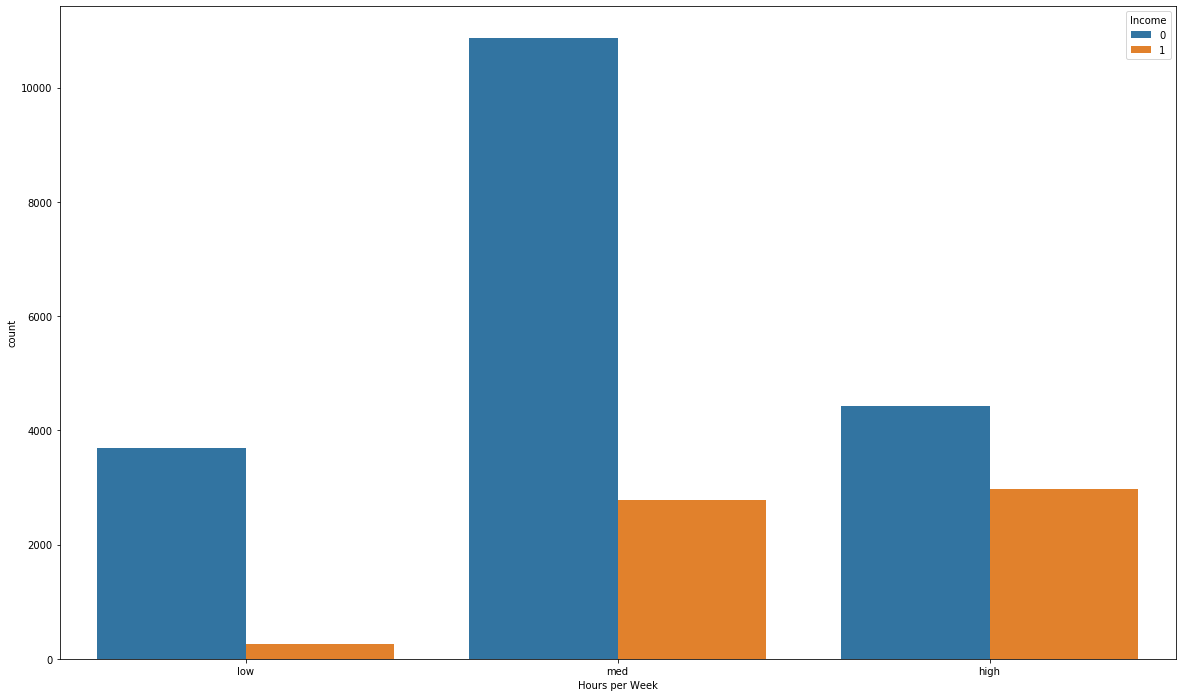

In [167]:
train_data['Hours per Week'] = pd.cut(train_data['Hours per Week'], 
                                   bins = [0, 30, 40, 100], 
                                   labels = ["low", "med", "high"])

sns.countplot(x = 'Hours per Week', hue = 'Income', data = train_data)
train_data["Hours per Week"].value_counts()

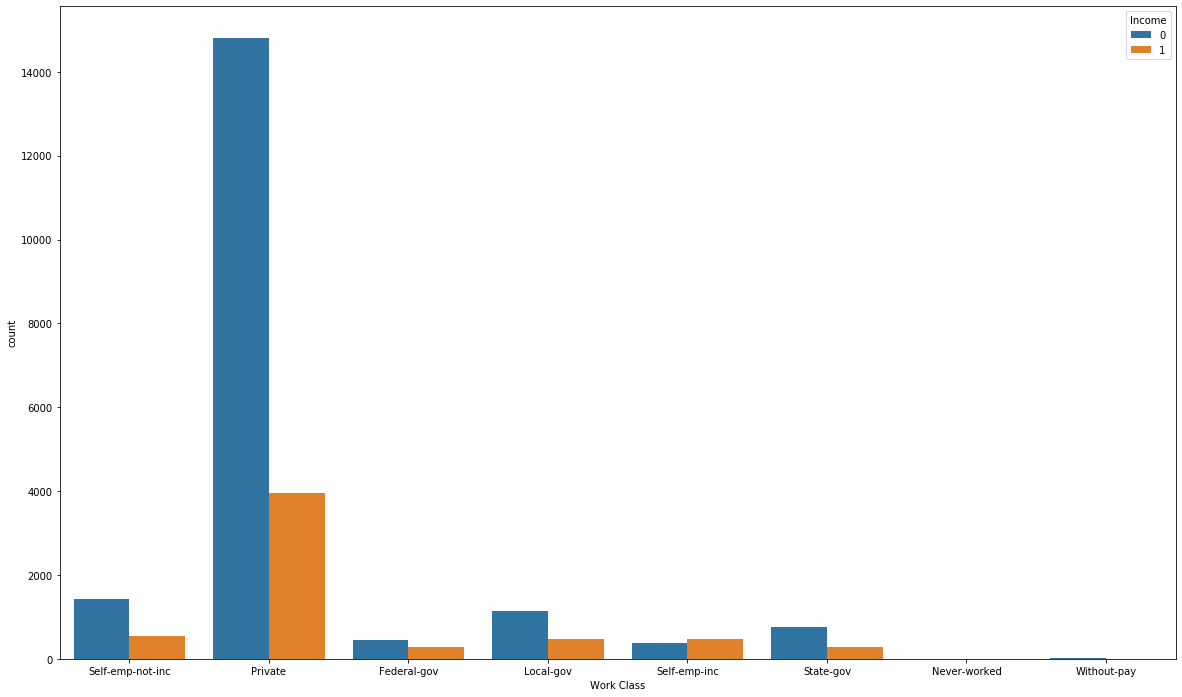

In [168]:
sns.countplot(x = 'Work Class', hue = 'Income', data = train_data)

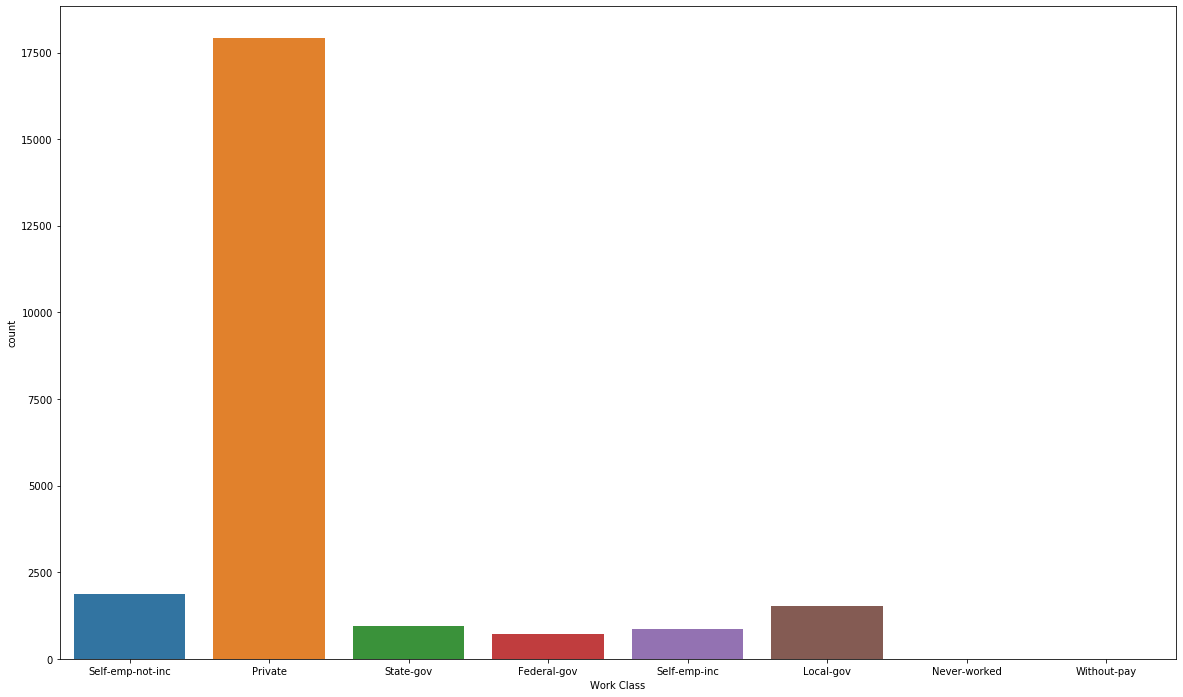

In [169]:
sns.countplot(x ='Work Class', data = test_data)

In [170]:
#train_data['Work Class'].replace(['Self-emp-not-inc', 'State-gov', 'Federal-gov', 'Self-emp-inc', 'Local-gov', 'Never-worked', 'Without-pay'], 'Other', inplace=True)
print(train_data)

        Age        Work Class     Education  Education Number  \
0      high  Self-emp-not-inc   Prof-school                15   
1       med  Self-emp-not-inc     Bachelors                13   
2       med           Private       HS-grad                 9   
3       med           Private       HS-grad                 9   
4       med           Private       HS-grad                 9   
...     ...               ...           ...               ...   
24995   low           Private       HS-grad                 9   
24996  high         Local-gov       HS-grad                 9   
24997   med           Private       Masters                14   
24998  high           Private       HS-grad                 9   
24999   low           Private  Some-college                10   

           Marital Status        Occupation    Relationship  \
0      Married-civ-spouse    Prof-specialty         Husband   
1      Married-civ-spouse   Exec-managerial         Husband   
2      Married-civ-spouse     

In [171]:
train_data.drop(['Education Number'], axis = 1, inplace = True)

In [172]:
train_data['Education'].replace(['11th', '9th', '7th-8th', '5th-6th', '10th', '1st-4th', 'Preschool', '12th'],
                             'School', inplace = True)
print(train_data['Education'].value_counts())
print(train_data)

HS-grad         8119
Some-college    5571
Bachelors       4044
School          3273
Masters         1369
Assoc-voc       1055
Assoc-acdm       812
Prof-school      450
Doctorate        307
Name: Education, dtype: int64
        Age        Work Class     Education      Marital Status  \
0      high  Self-emp-not-inc   Prof-school  Married-civ-spouse   
1       med  Self-emp-not-inc     Bachelors  Married-civ-spouse   
2       med           Private       HS-grad  Married-civ-spouse   
3       med           Private       HS-grad            Divorced   
4       med           Private       HS-grad  Married-civ-spouse   
...     ...               ...           ...                 ...   
24995   low           Private       HS-grad       Never-married   
24996  high         Local-gov       HS-grad  Married-civ-spouse   
24997   med           Private       Masters  Married-civ-spouse   
24998  high           Private       HS-grad            Divorced   
24999   low           Private  Some-college 

In [173]:
train_data['Marital Status'].value_counts()
# train_data['Marital Status'].replace(['Widowed', 'Separated', 'Married-spouse-absent', 'Married-AF-spouse'], 'Other', inplace=True)

Married-civ-spouse       11443
Never-married             8226
Divorced                  3412
Widowed                    837
Separated                  729
Married-spouse-absent      326
Married-AF-spouse           27
Name: Marital Status, dtype: int64

In [174]:
train_data['Relationship'].value_counts()

Husband           10111
Not-in-family      6483
Own-child          3879
Unmarried          2635
Wife               1162
Other-relative      730
Name: Relationship, dtype: int64

In [175]:
train_data['Race'].unique()
train_data['Race'].replace(['Black', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Other'], 'Other', inplace = True)
train_data['Race'].value_counts()

White    21359
Other     3641
Name: Race, dtype: int64

In [176]:
print(train_data['Country'].value_counts())

United-States                 22943
Mexico                          463
Philippines                     152
Germany                          99
Canada                           93
Puerto-Rico                      87
El-Salvador                      77
India                            76
Cuba                             70
England                          68
South                            61
China                            60
Italy                            48
Guatemala                        46
Jamaica                          46
Dominican-Republic               45
Poland                           45
Japan                            44
Vietnam                          43
Columbia                         41
Portugal                         36
Iran                             35
Taiwan                           33
Haiti                            30
Nicaragua                        27
Peru                             23
Greece                           20
Hong                        

In [177]:
countries = np.array(train_data['Country'].unique())
countries = np.delete(countries, 1)

In [178]:
train_data['Country'].replace(countries, 'Other', inplace = True)
print(train_data['Country'].value_counts())

United-States    22943
Other             2057
Name: Country, dtype: int64


In [179]:
print(train_data)
train_data["Sex"].value_counts()

        Age        Work Class     Education      Marital Status  \
0      high  Self-emp-not-inc   Prof-school  Married-civ-spouse   
1       med  Self-emp-not-inc     Bachelors  Married-civ-spouse   
2       med           Private       HS-grad  Married-civ-spouse   
3       med           Private       HS-grad            Divorced   
4       med           Private       HS-grad  Married-civ-spouse   
...     ...               ...           ...                 ...   
24995   low           Private       HS-grad       Never-married   
24996  high         Local-gov       HS-grad  Married-civ-spouse   
24997   med           Private       Masters  Married-civ-spouse   
24998  high           Private       HS-grad            Divorced   
24999   low           Private  Some-college       Never-married   

             Occupation    Relationship   Race     Sex Hours per Week  \
0        Prof-specialty         Husband  Other    Male            med   
1       Exec-managerial         Husband  White   

Male      16724
Female     8276
Name: Sex, dtype: int64

In [180]:
print(train_data)

        Age        Work Class     Education      Marital Status  \
0      high  Self-emp-not-inc   Prof-school  Married-civ-spouse   
1       med  Self-emp-not-inc     Bachelors  Married-civ-spouse   
2       med           Private       HS-grad  Married-civ-spouse   
3       med           Private       HS-grad            Divorced   
4       med           Private       HS-grad  Married-civ-spouse   
...     ...               ...           ...                 ...   
24995   low           Private       HS-grad       Never-married   
24996  high         Local-gov       HS-grad  Married-civ-spouse   
24997   med           Private       Masters  Married-civ-spouse   
24998  high           Private       HS-grad            Divorced   
24999   low           Private  Some-college       Never-married   

             Occupation    Relationship   Race     Sex Hours per Week  \
0        Prof-specialty         Husband  Other    Male            med   
1       Exec-managerial         Husband  White   

In [181]:
y = train_data['Income']
X = train_data.drop(['Income'], axis = 1)
X = pd.get_dummies(X)
print("Total features: {}".format(X.shape[1]))

Total features: 58


In [182]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 0)

In [183]:
from sklearn.metrics import f1_score, accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from keras import Sequential
from keras.layers import Dense, Dropout
from sklearn.pipeline import Pipeline

In [184]:
def build_keras_classifier(input_dim=58, hidden_layers=3, hidden_units=24, dropout_rate=0.1, optimizer='adam'):
    model = Sequential()
    model.add(Dense(24, input_dim=input_dim))
    model.add(Dropout(rate=dropout_rate))
    for i in range(hidden_layers):
        model.add(Dense(hidden_units, activation='relu'))
    model.add(Dense(1, activation='hard_sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['mae', 'acc'])
    return model

classifierstep = [('keras', KerasClassifier(build_keras_classifier, epochs=6, verbose=2))]

pipeline = Pipeline(classifierstep)

_SETTINGS = {
    'CLASSIFIER': 'keras',
    'ONE_HOT_ENCODE': True,
    'NORMALIZE': True,
    'GRID_PARAMS': dict(
        keras__hidden_layers=[1, 2, 3],
        keras__hidden_units=[1, 6, 12, 24],
        keras__dropout_rate=[0.05, 0.1, 0.3],
        keras__optimizer=['adam', 'sgd']
    )
}

In [185]:
classifiers = [GaussianNB(), 
               DecisionTreeClassifier(random_state = 0), 
               RandomForestClassifier(n_estimators = 100, random_state = 0), 
               GradientBoostingClassifier(random_state = 0),
               AdaBoostClassifier(random_state=0),
               LogisticRegression(penalty='l2'),
               KerasClassifier(build_keras_classifier, epochs=10, verbose=0),
               CategoricalNB()]
classifier_names = ["GN Bayes", 
                    "DTree", 
                    "RandFor", 
                    "GradBoost",
                    "AdaBoost",
                    "Logistic",
                    "Keras",
                    "CatNB"]
accuracies = []

In [186]:
for i in range(len(classifiers)):
    classifier = classifiers[i]
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    print("{}:".format(classifier_names[i]))
    print("F1 score: {:.2f}".format(f1_score(y_test, y_pred)))
    accuracy = accuracy_score(y_test, y_pred)*100
    print("Accuracy:", accuracy, "\n")
    accuracies.append(accuracy)

GN Bayes:
F1 score: 0.58
Accuracy: 68.56 

DTree:
F1 score: 0.60
Accuracy: 82.76 

RandFor:
F1 score: 0.64
Accuracy: 84.17333333333333 

GradBoost:
F1 score: 0.63
Accuracy: 84.81333333333333 

AdaBoost:
F1 score: 0.63
Accuracy: 84.73333333333333 

Logistic:
F1 score: 0.64
Accuracy: 84.86666666666667 

Keras:
F1 score: 0.65
Accuracy: 84.65333333333334 

CatNB:
F1 score: 0.63
Accuracy: 77.36 



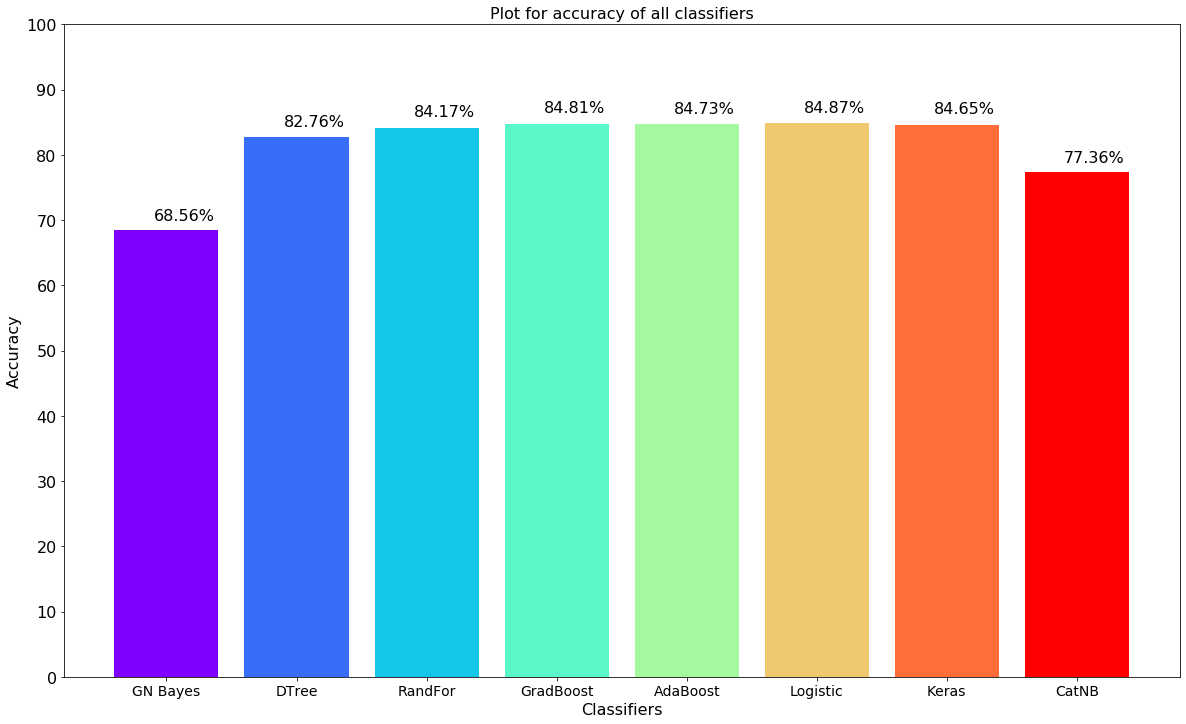

In [187]:
from matplotlib.cm import rainbow

plt.figure(figsize = (20, 12))
colors = rainbow(np.linspace(0, 1, len(classifiers)))
barplot = plt.bar(classifier_names, accuracies, color = colors)
plt.yticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], fontsize = 16)
plt.xticks(fontsize = 14)
plt.xlabel("Classifiers", fontsize = 16)
plt.ylabel("Accuracy", fontsize = 16)
plt.title("Plot for accuracy of all classifiers", fontsize = 16)
for i, bar in enumerate(barplot):
    plt.text(bar.get_x() + bar.get_width()/2 - 0.1, 
             bar.get_height()*1.02, 
             s = '{:.2f}%'.format(accuracies[i]), 
             fontsize = 16)

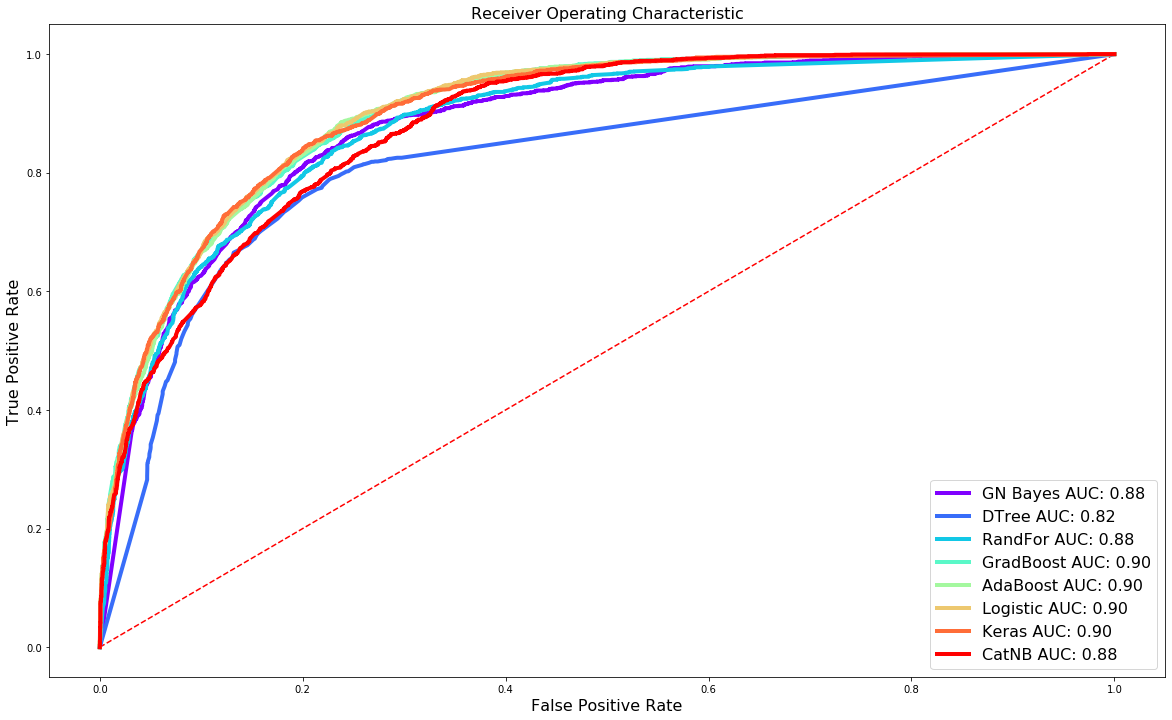

In [188]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize = (20, 12))
plt.plot([0,1], [0,1], 'r--')

for i in range(len(classifiers)):
    classifier = classifiers[i]
    probs = classifier.predict_proba(X_test)
    # Reading probability of second class
    probs = probs[:, 1]
    
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    label = classifier_names[i] + ' AUC:' + ' {0:.2f}'.format(roc_auc)
    plt.plot(fpr, tpr, c = colors[i], label = label, linewidth = 4)
    
plt.xlabel('False Positive Rate', fontsize = 16)
plt.ylabel('True Positive Rate', fontsize = 16)
plt.title('Receiver Operating Characteristic', fontsize = 16)
plt.legend(loc = 'lower right', fontsize = 16)

In [189]:
# Number of trees in random forest
c = [1, 1.5, 2, 2.5]
# Maximum number of levels in tree
max_iter = [100, 300, 400]
# Minimum number of samples required to split a node
dual = [False, True]
solver = ['lbfgs', 'sag', 'saga']


kclass = KerasClassifier(build_keras_classifier, epochs=3, verbose=2)


random_grid = {'C': c,
               'max_iter': max_iter,
               'dual': dual,
               'solver': solver
               }

print(random_grid)

{'C': [1, 1.5, 2, 2.5], 'max_iter': [100, 300, 400], 'dual': [False, True], 'solver': ['lbfgs', 'sag', 'saga']}


In [ ]:

kc = LogisticRegression(penalty='l2', random_state=0)

CV_gbc = GridSearchCV(kc, param_grid=random_grid, cv= 3, verbose=2, n_jobs=3)
CV_gbc.fit(X_train, y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:    4.8s


In [ ]:
print(CV_gbc.best_params_)
print(CV_gbc.best_score_)

In [ ]:
gbc = GradientBoostingClassifier(random_state = 0, n_estimators=30, min_samples_split=2,
                                max_features='sqrt', max_depth=5, learning_rate=.8)

kc = CV_gbc.best_estimator_

kc.fit(X, y)

In [ ]:
y_pred = kc.predict(X)
accuracy = accuracy_score(y, y_pred)*100
accuracies.append(accuracy)
print(accuracy)

In [ ]:
gbc =LogisticRegression(penalty='l1',C=1, class_weight={1:0.5, 0:0.5}, random_state=0, solver="saga", max_iter=1000)

gbc.fit(X, y)

In [ ]:
y_pred = gbc.predict(X)
accuracy = accuracy_score(y, y_pred)*100
print(accuracy)

In [ ]:
# Time to manipulate the test data
test_data["Age"] = test_data["Age"].astype(int)
test_data["Final Weight"] = test_data["Final Weight"].astype(int)
test_data["Education Number"] = test_data["Education Number"].astype(int)
test_data["Capital Gain"] = test_data["Capital Gain"].astype(int)
test_data["Capital Loss"] = test_data["Capital Loss"].astype(int)
test_data["Hours per Week"] = test_data["Hours per Week"].astype(int)

# Bin Ages
test_data['Age'] = pd.cut(test_data['Age'], bins = [0, 25, 50, 100], labels = ['low', 'med', 'high'])

# Dont need final weight
test_data.drop(['Final Weight'], axis=1, inplace=True)

# combine capital
test_data['Capital Diff'] = test_data['Capital Gain'] - test_data['Capital Loss']
test_data.drop(['Capital Gain'], axis = 1, inplace = True)
test_data.drop(['Capital Loss'], axis = 1, inplace = True)

test_data['Capital Diff'] = pd.cut(test_data['Capital Diff'], bins = [-5000, 5000, 100000], labels = ['low', 'high'])

# Bin Hours/week
test_data['Hours per Week'] = pd.cut(test_data['Hours per Week'], 
                                   bins = [0, 30, 40, 100], 
                                   labels = ['low', 'med', 'high'])

test_data.drop(['Education Number'], axis = 1, inplace = True)



test_data['Education'].replace(['11th', '9th', '7th-8th', '5th-6th', '10th', '1st-4th', 'Preschool', '12th'],
                             'School', inplace = True)

test_data['Race'].unique()
test_data['Race'].replace(['Black', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Other'],' Other', inplace = True)

countries = np.array(test_data['Country'].unique())
countries = np.delete(countries, 0)

test_data['Country'].replace(countries, 'Other', inplace = True)


X_test = test_data.drop(['ID'], axis = 1)
X_test = pd.get_dummies(X_test)

In [ ]:
print("Total features: {}".format(X_test.shape[1]))

In [ ]:
gbc = GradientBoostingClassifier(random_state = 0, n_estimators=30, min_samples_split=2,
                                max_features='sqrt', max_depth=5, learning_rate=.8)

kc.fit(X, y)
predictions = kc.predict_proba(X_test)
print(predictions)

In [ ]:

with open("results.txt", "w") as f:
    f.write("ID,Prediction\n")
    for i in range(0, len(predictions)):
        f.write(f'{i+1},{predictions[i][1]}\n')